## Resumo:

No dia a dia assistimos telejornais, acessamos sites, recebemos um monte de informação sobre a pandemia de Covid-19, mas parando para analisar, sabemos realmente qual é a real situações em termos de números nos locais do país?

Essa analise visa acompanhar a evolução da pandemia de Covid-19 no Brasil, com foco em cada Unidade da Federação e também nas regiões. Será usada a base de dados disponibilizada pelo brasil.io, iniciativa que foi desenvolvida de maneira independente e que tem como objetivo tornar acessível dados de interesse público para a população em geral. Então fica todos os créditos para eles e para mais informações sobre a iniciativa: https://brasil.io/manifesto/

O base de dados escolhida em específico é a **Covid-19 - caso**, filtrada com dados dos estados, desde o primeiro caso registrado até o da data de geração do arquivo, que foi dia 13/11/2020.

O que se busca é analisar de maneira objetivas os números absolutos, quebrá-los por estado, por região, por mês, para assim ver quais estados e regiões foram mais ou menos afetados, e com base nisso desenvolver hipóteses que deverão ser validadas, buscando uma análise mais pro lado demográfico.

## Importando bibliotecas e conhecendo base de dados

In [2]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Criando fonte de dados com tabela raw hospedada no github
path = 'https://raw.githubusercontent.com/doctumm/projetos_bootcamp/main/covid19-a84b1b6c93c14948bb920aaf0c40592b.csv'

In [3]:
# Importando dataset de casos Covid-19 Brasil (De Fev/2020 à Nov/2020) e checando as primeiras 5 linhas

df_test = pd.read_csv(path, sep = ',')
df_test.head()

,date,state,city,place_type,confirmed,deaths,is_last,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2020-11-13,AC,NaN,state,32661,707,True,894470,12,3651.43605,0.0216
1,2020-11-13,AL,NaN,state,92328,2288,True,3351543,27,2754.79085,0.0248
2,2020-11-13,AM,NaN,state,168596,4683,True,4207714,13,4006.83126,0.0278
3,2020-11-13,AP,NaN,state,54417,774,True,861773,16,6314.53991,0.0142
4,2020-11-13,BA,NaN,state,371378,7902,True,14930634,29,2487.35586,0.0213


In [4]:
# Checando as últimas 5 linhas
df_test.tail()

,date,state,city,place_type,confirmed,deaths,is_last,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
6536,2020-02-29,SP,NaN,state,2,0,False,46289333,35,0.00432,0.0
6537,2020-02-28,SP,NaN,state,2,0,False,46289333,35,0.00432,0.0
6538,2020-02-27,SP,NaN,state,1,0,False,46289333,35,0.00216,0.0
6539,2020-02-26,SP,NaN,state,1,0,False,46289333,35,0.00216,0.0
6540,2020-02-25,SP,NaN,state,1,0,False,46289333,35,0.00216,0.0


Fazendo uma breve análise, temos dados diários da evolução de casos e óbitos em cada estado do país. Esses números vão sendo somados aos do dia anterior e sempre apontarão o número total de casos e mortes naquela determinada data.

In [5]:
# Conhecendo os tipos de dados do dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6541 entries, 0 to 6540
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   date                            6541 non-null   object 
 1   state                           6541 non-null   object 
 2   city                            0 non-null      float64
 3   place_type                      6541 non-null   object 
 4   confirmed                       6541 non-null   int64  
 5   deaths                          6541 non-null   int64  
 6   is_last                         6541 non-null   bool   
 7   estimated_population            6541 non-null   int64  
 8   city_ibge_code                  6541 non-null   int64  
 9   confirmed_per_100k_inhabitants  6535 non-null   float64
 10  death_rate                      6541 non-null   float64
dtypes: bool(1), float64(3), int64(4), object(3)
memory usage: 517.5+ KB


## Tratando os dados

In [6]:
# Inicialmente vou excluir as colunas que considero não relevantes para análise e vamos recriar o DataFrame

df_main = df_test.drop(['city', 'place_type'], axis=1)
df_main.head()

,date,state,confirmed,deaths,is_last,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2020-11-13,AC,32661,707,True,894470,12,3651.43605,0.0216
1,2020-11-13,AL,92328,2288,True,3351543,27,2754.79085,0.0248
2,2020-11-13,AM,168596,4683,True,4207714,13,4006.83126,0.0278
3,2020-11-13,AP,54417,774,True,861773,16,6314.53991,0.0142
4,2020-11-13,BA,371378,7902,True,14930634,29,2487.35586,0.0213


In [7]:
# Convertendo a coluna date para um formato de data, para facilitar operações, caso seja necessário.

df_main['date'] = pd.to_datetime(df_main['date'])
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6541 entries, 0 to 6540
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            6541 non-null   datetime64[ns]
 1   state                           6541 non-null   object        
 2   confirmed                       6541 non-null   int64         
 3   deaths                          6541 non-null   int64         
 4   is_last                         6541 non-null   bool          
 5   estimated_population            6541 non-null   int64         
 6   city_ibge_code                  6541 non-null   int64         
 7   confirmed_per_100k_inhabitants  6535 non-null   float64       
 8   death_rate                      6541 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 415.3+ KB


Para cumprir com um dos objetivos que é a análise por região, vamos criar uma coluna com essa informação, e para isso vamos usar como parâmtro a coluna de city_ibge_code (A sugestão, assim como o código, foi dada pelo Igor Nascimento, na comunidade do Discord).

In [8]:
# Checando qual o código de cada estado.
df_main[['state', 'city_ibge_code']].drop_duplicates()

# O primeiro número sempre será referente a uma região, podemos ver que todos o estados da região norte tem o número 1 na frente, todos do nordeste tem o número 2

,state,city_ibge_code
0,AC,12
1,AL,27
2,AM,13
3,AP,16
4,BA,29
5,CE,23
6,DF,53
7,ES,32
8,GO,52
9,MA,21


In [9]:
# Será criado um dicionário para atribuir a cada número uma região.
regioes_dict = {'1': 'Norte', '2': 'Nordeste', '3': 'Sudeste', '4': 'Sul', '5': 'Centro-oeste'}

# A coluna região será dada pela função map, para acessar cada linha, e funçãolambda para acessar o primeiro número e retornar a região.
df_main['região'] = df_main['city_ibge_code'].map(lambda i: regioes_dict[str(i)[0]])
df_main.head(10)

,date,state,confirmed,deaths,is_last,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,região
0,2020-11-13,AC,32661,707,True,894470,12,3651.43605,0.0216,Norte
1,2020-11-13,AL,92328,2288,True,3351543,27,2754.79085,0.0248,Nordeste
2,2020-11-13,AM,168596,4683,True,4207714,13,4006.83126,0.0278,Norte
3,2020-11-13,AP,54417,774,True,861773,16,6314.53991,0.0142,Norte
4,2020-11-13,BA,371378,7902,True,14930634,29,2487.35586,0.0213,Nordeste
5,2020-11-13,CE,283463,9435,True,9187103,23,3085.44489,0.0333,Nordeste
6,2020-11-13,DF,219012,3808,True,3055149,53,7168.61927,0.0174,Centro-oeste
7,2020-11-13,ES,168358,3993,True,4064052,32,4142.61432,0.0237,Sudeste
8,2020-11-13,GO,267319,6029,True,7113540,52,3757.88988,0.0226,Centro-oeste
9,2020-11-13,MA,189321,4162,True,7114598,21,2661.02175,0.0220,Nordeste


In [10]:
# Por último, fica estabelecido que serão usados dados de meses completos, portanto vamos eliminar as linhas dos meses de fevereiro e novembro que não estão consolidados.

# Criando seleções para identificar linhas do mês de fevereiro e novembro.
selecao_fev = df_main['date'] <= '2020-02-29'
selecao_out = df_main['date'] >= '2020-11-01'

# Redefinindo DataFrame, removendo essas linhas por meio da seleção
df_main = df_main[~selecao_fev]
df_main = df_main[~selecao_out]

# Redefinindo índice
df_main.index = range(df_main.shape[0])

df_main.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,date,state,confirmed,deaths,is_last,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,região
0,2020-10-31,AC,30796,693,False,894470,12,3442.93269,0.0225,Norte
1,2020-10-31,AL,90789,2238,False,3351543,27,2708.87170,0.0247,Nordeste
2,2020-10-31,AM,161683,4543,False,4207714,13,3842.53778,0.0281,Norte
3,2020-10-31,AP,52175,748,False,861773,16,6054.37859,0.0143,Norte
4,2020-10-31,BA,353157,7622,False,14930634,29,2365.31818,0.0216,Nordeste


## Explorando os dados

In [11]:
df_main.head()

,date,state,confirmed,deaths,is_last,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,região
0,2020-10-31,AC,30796,693,False,894470,12,3442.93269,0.0225,Norte
1,2020-10-31,AL,90789,2238,False,3351543,27,2708.87170,0.0247,Nordeste
2,2020-10-31,AM,161683,4543,False,4207714,13,3842.53778,0.0281,Norte
3,2020-10-31,AP,52175,748,False,861773,16,6054.37859,0.0143,Norte
4,2020-10-31,BA,353157,7622,False,14930634,29,2365.31818,0.0216,Nordeste


Quero visualizar os números referentes ao último dia reportado para determinar quantos casos e quantas óbitos haviam naquela determinada data.

In [12]:
# Criando a variável de seleção com casos do último dia reportado.
selecao_last_day = df_main['date'] == '2020-10-31'

# Conferindo quantas colunas apresentam dados no dia 31/10, por meio da soma dos True que retornou da minha query
selecao_last_day.sum()

25

In [13]:
# Temos 27 estados, mas somente 25 registros de casos no dia 31/10. Vamos tentar ver agora os registros do dia anterior. Se houver 27, então temos os registros em todas UF.
selecao_last_day = df_main['date'] == '2020-10-30'
selecao_last_day.sum()

27

In [14]:
# Tenho todos os registros no dia 30/10, portanto fica definido que a data limite é o dia 30/10/2020.
# O impacto que um dia completo de dados causa pode ser alto, mas aqui busca-se simplificar o estudo.
# E é importante salientar que o dia 31/10 foi um dia de final de semana, e a notificação costuma ser menor nesses dias, portanto o impacto pode ser menor.

# Criando DataFrame com os números do dia último dia de registros e somando os casos

last_day = df_main[selecao_last_day]
confirmed_total = last_day['confirmed'].sum()

# Realizando a soma do total de mortes
deaths_total = last_day['deaths'].sum()

Conferindo números absolutos de casos, óbitos e taxa de mortalidade




In [15]:

print(f'Temos o total de {confirmed_total} casos confirmados e {deaths_total} óbitos até o dia 30/10/2020, de acordo com os últimos dados disponibilizados pelas secretarias de saúde dos estados')
print(f'Temos uma taxa de mortalidade de {((deaths_total / confirmed_total) * 100).round(2)} %')

Temos o total de 5524593 casos confirmados e 159680 óbitos até o dia 30/10/2020, de acordo com os últimos dados disponibilizados pelas secretarias de saúde dos estados
Temos uma taxa de mortalidade de 2.89 %


In [16]:
# Conferindo o total de casos por estado
cases = df_main[['state', 'confirmed']]
cases = cases[selecao_last_day].sort_values(by = 'confirmed', ascending = False)
cases.head()

,state,confirmed
50,SP,1113788
35,MG,358971
29,BA,352700
43,RJ,309496
30,CE,273743


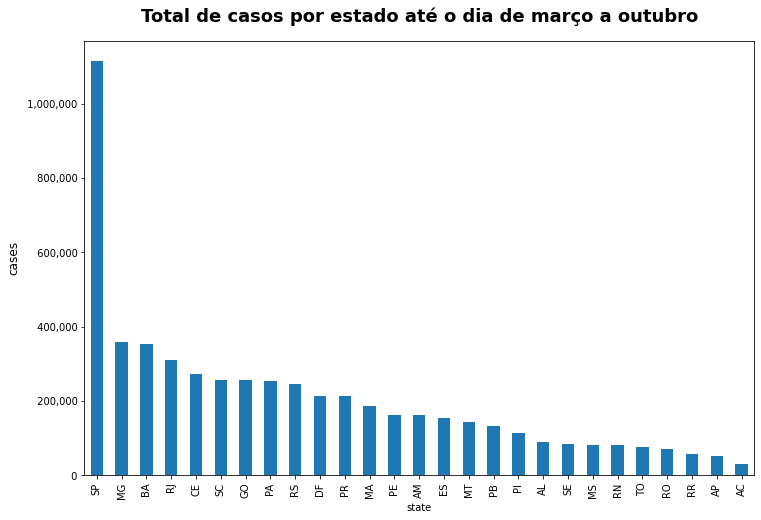

In [40]:
# Plotando o gráfico de total de casos por estado

ax = cases.plot(x = 'state', y = 'confirmed', kind = 'bar', figsize= (12,8))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x: ,.0f}'))

plt.title('Total de casos por estado até o dia de março a outubro', fontsize = 18, fontweight = 'bold', y = 1.03)
plt.ylabel('cases', fontsize= 12)
ax.get_legend().remove()
plt.show()

In [18]:
# Conferindo o total de óbitos por estado

deaths = df_main[['state', 'deaths']]
deaths = deaths[selecao_last_day].sort_values(by = 'deaths', ascending = False)
deaths.head()

,state,deaths
50,SP,39255
43,RJ,20565
30,CE,9344
35,MG,9015
40,PE,8609


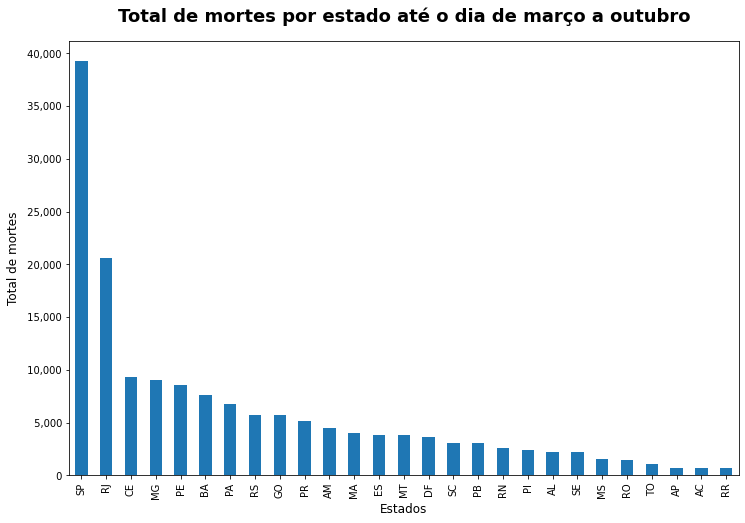

In [19]:
# Plotando gráfico do total de mortes
ax = deaths.plot(x = 'state', y = 'deaths', kind = 'bar', figsize= (12,8))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x: ,.0f}'))

plt.title('Total de mortes por estado até o dia de março a outubro', fontsize = 18, fontweight = 'bold', y = 1.03)
plt.xlabel('Estados', fontsize = 12)
plt.ylabel('Total de mortes', fontsize= 12)
ax.get_legend().remove()
plt.show()

São Paulo tem disparado o maior número de casos e de mortes registradas por Covid-19. Não à toa, se trata do estado mais populoso do Brasil, e possui a maior aglomeração urbana do pais que é a região metropolitana de São Paulo. 

Outro caso interessante é do estado do Rio de Janeiro, pode-se ver que é o 4º estado com mais casos, mas o segundo com mais mortes. E aí temos duas hipóteses, ou o sistema de saúde não oferece acesso a um bom tratamento, e por isso a taxa de morte foi de fato maior, ou há uma subnotificação dos casos confirmados.


In [20]:
# Checando a taxa de mortalidade, pelo número de mortes/número de casos

death_rate = df_main[['state', 'death_rate']]
death_rate = death_rate[selecao_last_day].sort_values(by = 'death_rate', ascending = False)
death_rate['death_rate'] = death_rate['death_rate'] * 100
death_rate.head()

,state,death_rate
43,RJ,6.64
40,PE,5.30
50,SP,3.52
30,CE,3.41
44,RN,3.17


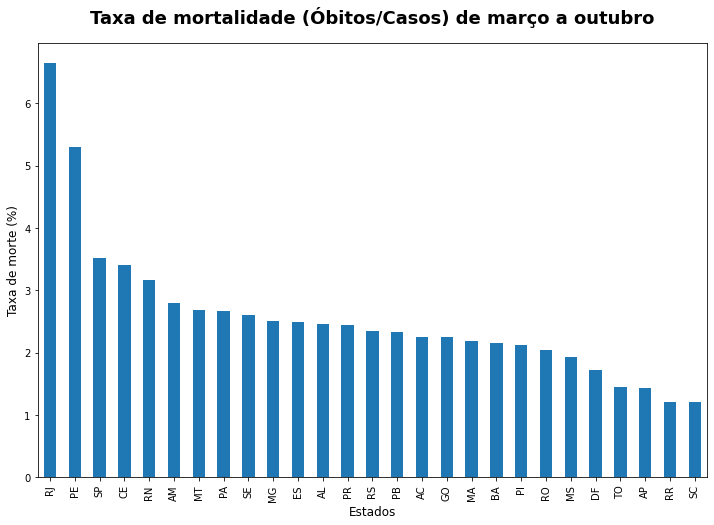

In [21]:
# Plotando o gráfico da taxa de morte

ax = death_rate.plot(x = 'state', y = 'death_rate', kind = 'bar', figsize= (12,8))

plt.title('Taxa de mortalidade (Óbitos/Casos) de março a outubro', fontsize = 18, fontweight = 'bold', y = 1.03)
plt.xlabel('Estados', fontsize = 12)
plt.ylabel('Taxa de morte (%)', fontsize= 12)
ax.get_legend().remove()
plt.show()

A Taxa de mortalidade aqui é calculada apenas pela razão de mortes x casos confirmados. Ela pode não refletir a realidade devido ao fato do Brasil não fazer muitos testes, e se estima que uma parcela maior da população contraiu o vírus. Mas serve como um indicativo que demonstra ao menos um menor controle de pandemia, pois a média de mortalidade no país é 2,89% com base nos dados totais.

Rio e Pernambuco são os estados que mais distoam dessa média, portando pode-se considerar estados que tem um controle pior da pandemia, ou pelo fato de realmente ter taxas de mortalidades elevadas, ou pelo fato de não aplicarem muitos testes, o que infla essa taxa.  Vamos ver como é o comportamento quando analisamos somente os casos e mortes por 100k de habitantes

In [22]:
 # Já temos uma variável de quantidade de casos a cada 100k de habitantes, agora vamos criar uma para o número de óbitos para essa proporção.
last_day['deaths_per_100k'] =  last_day['deaths'] / (last_day['estimated_population'] / 100000)
last_day.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,state,confirmed,deaths,is_last,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,região,deaths_per_100k
25,2020-10-30,AC,30758,693,False,894470,12,3438.68436,0.0225,Norte,77.476047
26,2020-10-30,AL,90671,2234,False,3351543,27,2705.35094,0.0246,Nordeste,66.655866
27,2020-10-30,AM,161434,4528,False,4207714,13,3836.62007,0.0280,Norte,107.611877
28,2020-10-30,AP,52030,747,False,861773,16,6037.55281,0.0144,Norte,86.681760
29,2020-10-30,BA,352700,7600,False,14930634,29,2362.25736,0.0215,Nordeste,50.902058


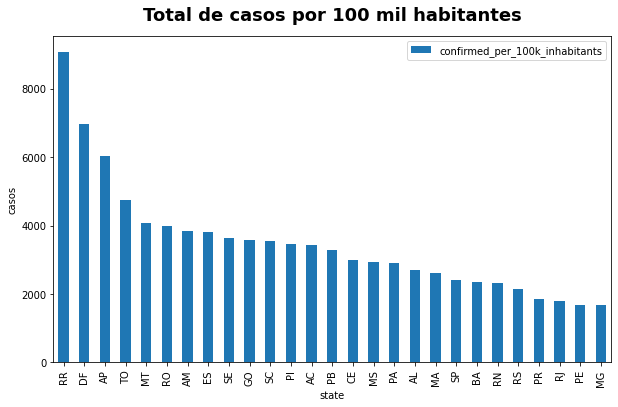

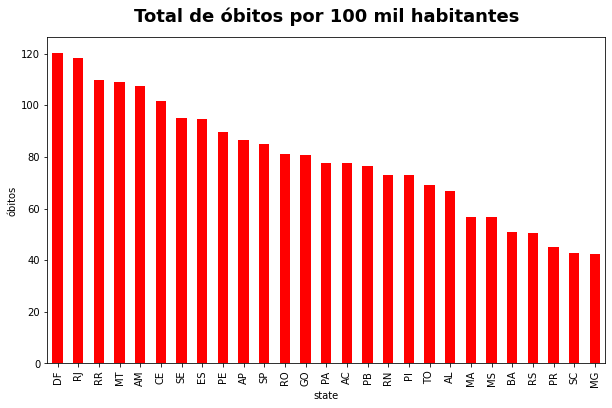

In [23]:
# Gráfico dos casos por 100 mil habitantes
ax = last_day.sort_values(by = 'confirmed_per_100k_inhabitants', ascending = False).plot(x = 'state', y = 'confirmed_per_100k_inhabitants', kind = 'bar', figsize=(10,6))
plt.title('Total de casos por 100 mil habitantes', fontsize = 18, fontweight = 'bold', y = 1.03)
plt.ylabel('casos', fontsize= 10)

# Gráfico dos mortes por 100 mil habitantes
ax = last_day.sort_values(by = 'deaths_per_100k', ascending = False).plot(x = 'state', y = 'deaths_per_100k', kind = 'bar', figsize=(10,6), color = 'red')
plt.title('Total de óbitos por 100 mil habitantes', fontsize = 18, fontweight = 'bold', y = 1.03)
plt.ylabel('óbitos', fontsize= 10)

ax.get_legend().remove()
plt.show()

Esse gráfico nos dá um panorama melhor de como os números realmente impactaram na população de cada estado.

Pode-se ver aqui que o estado de Roraima é o que mais teve casos confirmados a cada 100 mil habitantes, e teve uma quantidade considerável também de mortes. Por essa análise pode-se dizer que foi bem afetado.

Podemos notar também que os números são altos nos estados da região norte, o que levanta a hipotese dessa ter sido a região mais afetada. Em contrapartida, a região sul registrou números mais baixos, o que leva a crer que foi a região que sofreu menor impacto.

#Explorando dados por região


In [24]:
# Conferindo novamente o cabeçalho da base de dados
last_day.head()

,date,state,confirmed,deaths,is_last,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,região,deaths_per_100k
25,2020-10-30,AC,30758,693,False,894470,12,3438.68436,0.0225,Norte,77.476047
26,2020-10-30,AL,90671,2234,False,3351543,27,2705.35094,0.0246,Nordeste,66.655866
27,2020-10-30,AM,161434,4528,False,4207714,13,3836.62007,0.0280,Norte,107.611877
28,2020-10-30,AP,52030,747,False,861773,16,6037.55281,0.0144,Norte,86.681760
29,2020-10-30,BA,352700,7600,False,14930634,29,2362.25736,0.0215,Nordeste,50.902058


In [25]:
# Criando variável de para agrupar os números por região, em cima do DataFrame dos dados do último dia.
grupo_regiao = last_day.groupby('região')

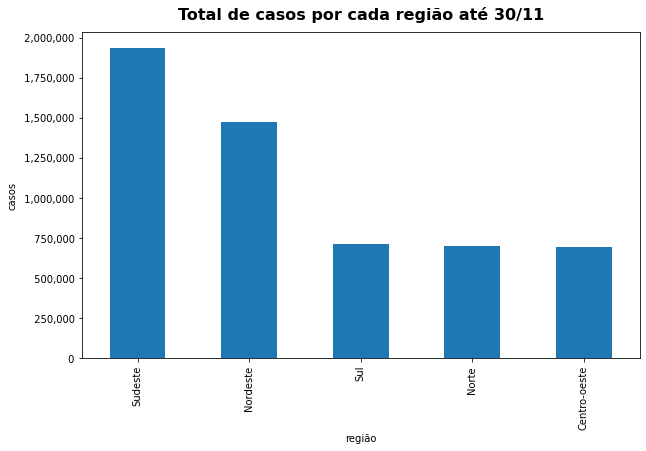

In [26]:
# Plotando gráfico de números absolutos de casos por região
ax = grupo_regiao['confirmed'].sum().sort_values(ascending = False).plot(figsize=(10,6), kind = 'bar')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x: ,.0f}'))

plt.title('Total de casos por cada região até 30/11', fontsize = 16, fontweight = 'bold', y = 1.02)
plt.ylabel('casos')

plt.show()

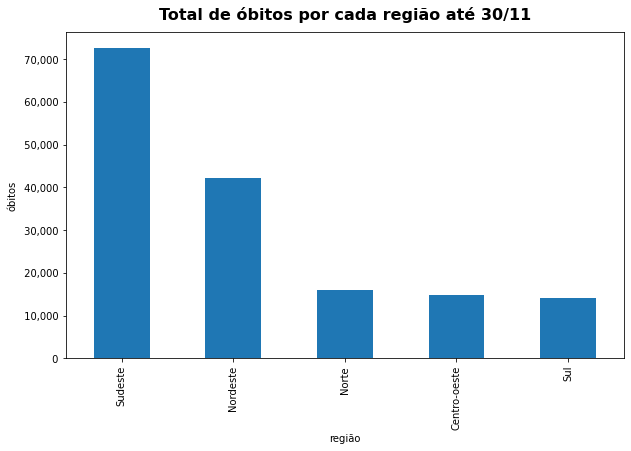

In [27]:
# Plotando o gráfico com os números absolutos de óbitos por região
ax = grupo_regiao['deaths'].sum().sort_values(ascending = False).plot(figsize=(10,6), kind = 'bar')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x: ,.0f}'))

plt.title('Total de óbitos por cada região até 30/11', fontsize = 16, fontweight = 'bold', y = 1.02)
plt.ylabel('óbitos')

plt.show()

Em termos de números absolutos, a proporção é a mesma, com o sudeste sendo a região mais afetada em números de casos e de mortes, o nordeste vindo em seguida, e as outras regiões estando praticamente em um mesmo patamar. Vamos agora fazer a mesma análise para casos a cada 100k de habitantes por região.

In [28]:
# Vamos refazer a métrica de casos por 100k de habitantes
confirmed_100k = grupo_regiao['confirmed'].sum() / (grupo_regiao['estimated_population'].sum() / 100000)
deaths_100k = grupo_regiao['deaths'].sum() / (grupo_regiao['estimated_population'].sum() / 100000)

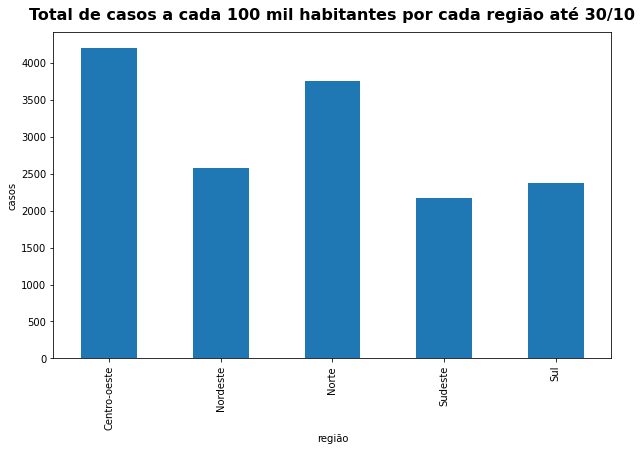

In [29]:
ax = confirmed_100k.plot(kind='bar', figsize=(10,6))

plt.title('Total de casos a cada 100 mil habitantes por cada região até 30/10', fontsize = 16, fontweight = 'bold', y = 1.02)
plt.ylabel('casos')

plt.show()

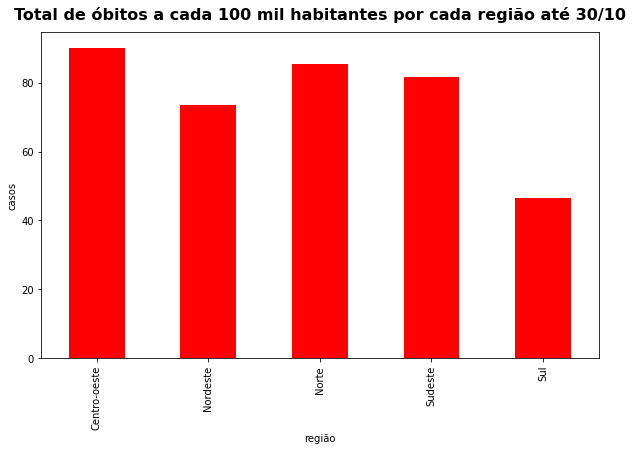

In [30]:
ax = deaths_100k.plot(kind='bar', figsize=(10,6), color ='red')

plt.title('Total de óbitos a cada 100 mil habitantes por cada região até 30/10', fontsize = 16, fontweight = 'bold', y = 1.02)
plt.ylabel('casos')

plt.show()

Por este gráfico podemos ver que o centro-oeste teve mais casos e mortes a cada 100 mil habitantes, então como essa análise é um indicativo de como os números absolutos impactam com relação à população em geral, podemos dizer que foi a região mais afetada, embora o norte tenha núúmeros próximos e também foi bem afetada. E a região Sul realmente foi a menos afetada.

Outro ponto interessante, o Sudeste teve um número menor de casos em comparação a outras regiões, mas teve um número alto de óbitos.

#Evolução dos números da pandemia

Verificando a evolução dos casos e óbitos confirmados ao longo do tempo (até outubro)

In [31]:
# Como os casos vão sendo acumulados diariamente, para medir a quantidade de casos em um mês só vai me importar o total de casos no último dia. 
# Se eu somar os casos de um mês portanto ele vai me retornar um valor fora da realidade, portanto opta-se por criar um dataframe somente com dados do último dia de cada mês.
datas = ['2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-30']
selecao = df_main['date'].isin(datas)
last_day_mes = df_main[selecao]
last_day_mes.head()

,date,state,confirmed,deaths,is_last,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,região
25,2020-10-30,AC,30758,693,False,894470,12,3438.68436,0.0225,Norte
26,2020-10-30,AL,90671,2234,False,3351543,27,2705.35094,0.0246,Nordeste
27,2020-10-30,AM,161434,4528,False,4207714,13,3836.62007,0.0280,Norte
28,2020-10-30,AP,52030,747,False,861773,16,6037.55281,0.0144,Norte
29,2020-10-30,BA,352700,7600,False,14930634,29,2362.25736,0.0215,Nordeste


In [32]:
last_day_mes.tail()

,date,state,confirmed,deaths,is_last,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,região
5756,2020-03-31,RS,305,4,False,11422973,43,2.67006,0.0131,Sul
5757,2020-03-31,SC,235,2,False,7252502,42,3.24026,0.0085,Sul
5758,2020-03-31,SE,19,0,False,2318822,28,0.81938,0.0000,Nordeste
5759,2020-03-31,SP,2339,136,False,46289333,35,5.05300,0.0581,Sudeste
5760,2020-03-31,TO,12,0,False,1590248,17,0.75460,0.0000,Norte


In [33]:
# Criando novo DataFrame com os meses e a quantidade total de casos e mortes em cada um
meses = ['Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro']
evolutivo_mes = pd.DataFrame(index = meses, columns = ['Casos', 'Mortes'])

In [34]:
# Somando o número de casos para cada mês
casos_mar = last_day_mes[last_day_mes['date'] == '2020-03-31']['confirmed'].sum()
casos_abr = last_day_mes[last_day_mes['date'] == '2020-04-30']['confirmed'].sum() - last_day_mes[last_day_mes['date'] == '2020-03-31']['confirmed'].sum() 
casos_mai = last_day_mes[last_day_mes['date'] == '2020-05-31']['confirmed'].sum() - last_day_mes[last_day_mes['date'] == '2020-04-30']['confirmed'].sum()
casos_jun = last_day_mes[last_day_mes['date'] == '2020-06-30']['confirmed'].sum() - last_day_mes[last_day_mes['date'] == '2020-05-31']['confirmed'].sum()
casos_jul = last_day_mes[last_day_mes['date'] == '2020-07-31']['confirmed'].sum() - last_day_mes[last_day_mes['date'] == '2020-06-30']['confirmed'].sum()
casos_ago = last_day_mes[last_day_mes['date'] == '2020-08-31']['confirmed'].sum() - last_day_mes[last_day_mes['date'] == '2020-07-31']['confirmed'].sum()
casos_set = last_day_mes[last_day_mes['date'] == '2020-09-30']['confirmed'].sum() - last_day_mes[last_day_mes['date'] == '2020-08-31']['confirmed'].sum()
casos_out = last_day_mes[last_day_mes['date'] == '2020-10-30']['confirmed'].sum() - last_day_mes[last_day_mes['date'] == '2020-09-30']['confirmed'].sum()

# Somando o número de mortes para cada mês

mortes_mar = last_day_mes[last_day_mes['date'] == '2020-03-31']['deaths'].sum() 
mortes_abr = last_day_mes[last_day_mes['date'] == '2020-04-30']['deaths'].sum() - last_day_mes[last_day_mes['date'] == '2020-03-31']['deaths'].sum() 
mortes_mai = last_day_mes[last_day_mes['date'] == '2020-05-31']['deaths'].sum() - last_day_mes[last_day_mes['date'] == '2020-04-30']['deaths'].sum()
mortes_jun = last_day_mes[last_day_mes['date'] == '2020-06-30']['deaths'].sum() - last_day_mes[last_day_mes['date'] == '2020-05-31']['deaths'].sum()
mortes_jul = last_day_mes[last_day_mes['date'] == '2020-07-31']['deaths'].sum() - last_day_mes[last_day_mes['date'] == '2020-06-30']['deaths'].sum()
mortes_ago = last_day_mes[last_day_mes['date'] == '2020-08-31']['deaths'].sum() - last_day_mes[last_day_mes['date'] == '2020-07-31']['deaths'].sum()
mortes_set = last_day_mes[last_day_mes['date'] == '2020-09-30']['deaths'].sum() - last_day_mes[last_day_mes['date'] == '2020-08-31']['deaths'].sum()
mortes_out = last_day_mes[last_day_mes['date'] == '2020-10-30']['deaths'].sum() - last_day_mes[last_day_mes['date'] == '2020-09-30']['deaths'].sum()

In [35]:
# Criando listas para adicionar os valores calculados ao novo DataFrame
casos_mes = [casos_mar, casos_abr, casos_mai, casos_jun, casos_jul, casos_ago, casos_set, casos_out]
mortes_mes = [mortes_mar, mortes_abr, mortes_mai, mortes_jun, mortes_jul, mortes_ago, mortes_set, mortes_out]

In [36]:
# Criando as colunas de evolução de casos e mortes
evolutivo_mes['Casos'] = casos_mes
evolutivo_mes['Mortes'] = mortes_mes

In [37]:
evolutivo_mes

,Casos,Mortes
Março,5824,202
Abril,81302,5778
Maio,428968,23387
Junho,896570,30424
Julho,1257787,32936
Agosto,1244378,28891
Setembro,902536,22346
Outubro,707228,15716


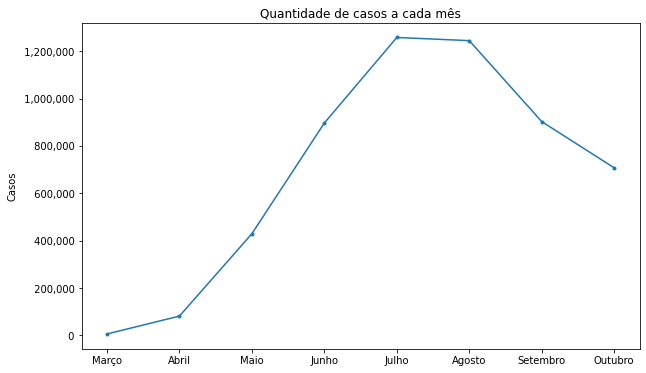

In [38]:
# Plotando gráfico de evolucao dos casos ao longo dos meses

ax = evolutivo_mes['Casos'].plot(figsize=(10,6), marker = '.')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x: ,.0f}'))


ax.set_title('Quantidade de casos a cada mês')
plt.ylabel('Casos')

plt.show()

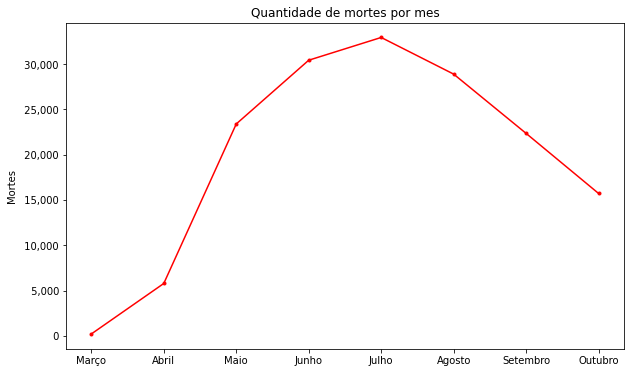

In [39]:
# # Plotando gráfico de evolucao de mortes ao longo dos meses
ax = evolutivo_mes['Mortes'].plot(figsize=(10,6), marker = '.', color = 'red')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x: ,.0f}'))


ax.set_title('Quantidade de mortes por mes')
plt.ylabel('Mortes')

plt.show()

No primeiro mês, a evolução de casos e óbitos foi praticamente a mesma, mas a partir de abril, houve um crescimento exponencial, que veio a diminuir apenas a partir de agosto, e desde então vem decaindo, sendo que os óbitos decaíram quase que de maneira linear.

Primeiro sobre esse aumento, foi o pico da pandemia, o momento em que houve um boom de casos, eles começaram a crescer muito rápido, o que aumentou a taxa de transmissão, o que fez mais pessoas contraírem o vírus e que mais pessoas também viessem a óbito. Esse pico portanto ocorreu entre maio e agosto. Foram 3 meses inteiros praticamente de pico, o que pode ser considerado um tempo muito elevado. 

A partir de agosto esses números começaram a cair, e vêm diminuindo desde então, até o final de Outubro. Isso pode se dever ao fato das medidas de isolamento começarem a surtir efeito, ainda que as medidas aqui no Brasil tenha sido mais rígidas, e também que as pessoas começaram a usar mais máscaras. Mas isso não quer dizer que os números agora estejam bons, o ideal, para considerar que estivessemos controlando a pandemia, seria termos um número baixo de casos e óbitos, parecidos com números de março e abril, mas podemos ver que não é isso que aconteceu.


# Conclusão

Os numeros aqui analisados serviram como base para entender como cada estado e região foram impactados pela pandemia, em termos de números absolutos. Podemos constatar que:

- As regiões Centro-Oeste e Norte foram as mais afetadas, em termos de população em geral, embora essas tenham menor densidade demografica, e correspondam a apenas 16% da população total do país.

- A região sul foi a região menos afetada, segundo os números do estudo.

- Rio de Janeiro e Pernembuco são estados que tiveram maior taxa de óbitos.

- O pico da Pandemia foi entre os meses de maio e de agosto, mas embora os números tenham diminuído, nem de perto alcançamos o mesmo patamar de março e abril.

E com base nessas observações, foram levantadas algumas hipóteses que serão exploradas no decorrer do curso, de acordo com a realização dos novos módulos e de novos conhecimentos adquiridos.

- A pandemia teve mais impacto no interior que nas capitais.

- A questão de clima, gera impacto na evolução da pandemia?

- Houve subnotificação de casos no estado do Rio de Janeiro e Pernambuco.

- A região sul, por ter um clima mais frio e ter uma tendência maior para desenvolver doenças respiratórias, têm uma maior facilidade no tratamento dos casos, na prevenção e também uma propensão maior de resistência ao vírus.

- A campanha de vacinação de gripe trouxe alguma amenização dos casos?
